<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Establishing-cutoffs" data-toc-modified-id="Establishing-cutoffs-1">Establishing cutoffs</a></span><ul class="toc-item"><li><span><a href="#Window-size-50" data-toc-modified-id="Window-size-50-1.1">Window size 50</a></span></li><li><span><a href="#Window-size-100" data-toc-modified-id="Window-size-100-1.2">Window size 100</a></span></li><li><span><a href="#Window-size-25" data-toc-modified-id="Window-size-25-1.3">Window size 25</a></span></li><li><span><a href="#Window-size-median-of-algorithm" data-toc-modified-id="Window-size-median-of-algorithm-1.4">Window size median of algorithm</a></span></li><li><span><a href="#Randomized-sequences" data-toc-modified-id="Randomized-sequences-1.5">Randomized sequences</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.6">Summary</a></span></li><li><span><a href="#Info-from-literature" data-toc-modified-id="Info-from-literature-1.7">Info from literature</a></span></li></ul></li><li><span><a href="#Comparison-between-hits-and-proteome" data-toc-modified-id="Comparison-between-hits-and-proteome-2">Comparison between hits and proteome</a></span></li></ul></div>

In [1]:
#from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
# Imports
import numpy as np
import scipy as sp
import pandas as pd
import random
import chargepatterns as cp

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

In [5]:
# Import proteome data
scerprot = []
for record in SeqIO.parse("../data/orf_trans_all_R64-2-1_20150113.fasta", "fasta"):
    scerprot.append(record)

## Establishing cutoffs

### Window size 50

In [6]:
scer_fclist50 = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    windowsize = 50
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scer_fclist50.append(fraccharge)
        i += 5

In [7]:
fc50_mean = np.mean(scer_fclist50)
fc50_sigma = np.std(scer_fclist50)

fc50_2sigma = fc50_mean + 2*fc50_sigma
fc50_2sigma

0.42130804856614906

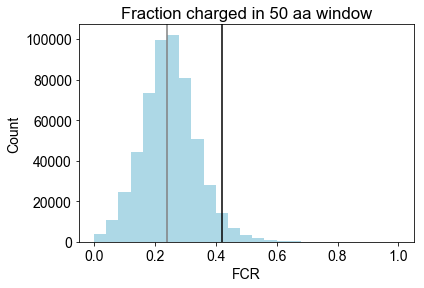

In [10]:
plt.hist(scer_fclist50, bins = 25, color = 'lightblue')
plt.axvline(x=fc50_mean, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=fc50_2sigma, ymin=0, ymax=100000, color = 'k')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged in 50 aa window')
plt.show()

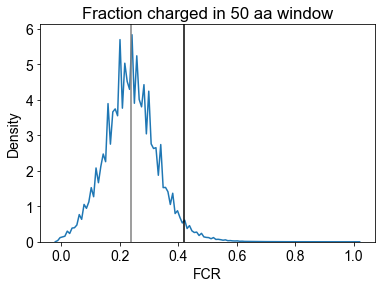

In [11]:
sns.kdeplot(scer_fclist50, bw=0.007)
plt.axvline(x=fc50_mean, ymin=0, ymax=6, color = 'gray')
plt.axvline(x=fc50_2sigma, ymin=0, ymax=6, color = 'k')
plt.title('Fraction charged in 50 aa window')
plt.xlabel('FCR')
plt.ylabel('Density')
plt.show()

### Window size 100

In [12]:
scer_fclist100 = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    windowsize = 100
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scer_fclist100.append(fraccharge)
        i += 5

In [13]:
fc100_mean = np.mean(scer_fclist100)
fc100_sigma = np.std(scer_fclist100)

fc100_2sigma = fc100_mean + 2*fc100_sigma
fc100_2sigma

0.39078439419686906

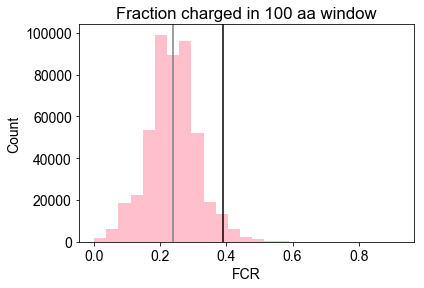

In [14]:
plt.hist(scer_fclist100, bins = 25, color = 'pink')
plt.axvline(x=fc100_mean, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=fc100_2sigma, ymin=0, ymax=100000, color = 'k')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged in 100 aa window')
plt.show()

### Window size 25

In [15]:
scer_fclist25 = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    windowsize = 25
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scer_fclist25.append(fraccharge)
        i += 5

In [16]:
fc25_mean = np.mean(scer_fclist25)
fc25_sigma = np.std(scer_fclist25)

fc25_2sigma = fc25_mean + 2*fc25_sigma
fc25_2sigma

0.4632151113428208

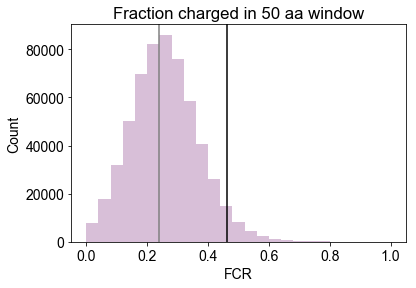

In [17]:
plt.hist(scer_fclist25, bins = 25, color = 'thistle')
plt.axvline(x=fc25_mean, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=fc25_2sigma, ymin=0, ymax=100000, color = 'k')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged in 50 aa window')
plt.show()

### Window size median of algorithm

55

In [21]:
scer_fclist2 = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    windowsize = 55
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scer_fclist2.append(fraccharge)
        i += 5

In [22]:
fc55_mean = np.mean(scer_fclist2)
fc55_sigma = np.std(scer_fclist2)

fc55_2sigma = fc55_mean + 2*fc55_sigma
fc55_2sigma

0.4165951049369025

0.4 ish seems to be a reasonable cutoff -- it represents regions that are more than two standard deviations higher than the mean fraction of charged residues for regions in the yeast proteome.

### Randomized sequences

In [23]:
import string

def get_aa_freqs(seq, counts = False, sort_output = True, gaps = False):
    """
    Arguments:
    seq: a sequences (string representing a protein, drawn from the 20 naturally-occuring amino acids)
    counts: bool, whether to return the counts in each category or the frequencies. False (returns freqs) by default.
    sort_output: bool, whether to return the frequencies or counts in alphabetically sorted order. True by default.
    If false, the categories will also be returned.
    Returns:
    aas: if unsorted, an iterable of the categories (amino acids) represented for each sequence
    freqs: an interable of the frequency of each category in the sequence.
        The indices match the categories in the same index in 'aas'.
        If counts is True, this will be raw counts rather than frequency.
        If sort_output is True only the frequencies will be returned, the assumed order is the
        amino acids in alphabetical order.
    """
    # Amino acids
    forbidden = ['B', 'J', 'O', 'U', 'X', 'Z']
    aas = []
    for a in string.ascii_uppercase:
        if a not in forbidden:
            aas.append(a)
    if gaps:
        aas.append('-')
    
    all_seq_aas = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_aas, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_aas = np.setxor1d(aas, seq_aas)

    seq_aas = np.append(seq_aas, zero_freq_aas)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_aas.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_aas.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_aas.append(seq_aas)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_aas, all_seq_freqs)

In [24]:
# Average aa composition of yeast proteome
scercomp = np.zeros(20)
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    scercomp = sp.add(scercomp, get_aa_freqs(seq))
scercomp = sp.divide(scercomp, len(scerprot))[0]

In [25]:
scercomp

array([0.05615162, 0.01599199, 0.05277263, 0.06027923, 0.04814328,
       0.05052868, 0.02240347, 0.0651241 , 0.07245147, 0.097187  ,
       0.02293504, 0.05669517, 0.04380565, 0.03824247, 0.04716623,
       0.08879706, 0.05789731, 0.05791357, 0.01091581, 0.03459823])

In [26]:
# Amino acids
forbidden = ['B', 'J', 'O', 'U', 'X', 'Z']
aas = []
for a in string.ascii_uppercase:
    if a not in forbidden:
        aas.append(a)    
        
scernull = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    seqlen = len(seq)
    nullseq = "".join(np.random.choice(aas, size=seqlen, p=scercomp))
    scernull.append(nullseq)

In [27]:
scernull_fclist = []
for seq in scernull:
    windowsize = 50
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scernull_fclist.append(fraccharge)
        i += 5

In [28]:
fcnull50_mean = np.mean(scernull_fclist)
fcnull50_sigma = np.std(scernull_fclist)

fcnull50_2sigma = fcnull50_mean + 2*fcnull50_sigma
fcnull50_2sigma

0.35234681486646074

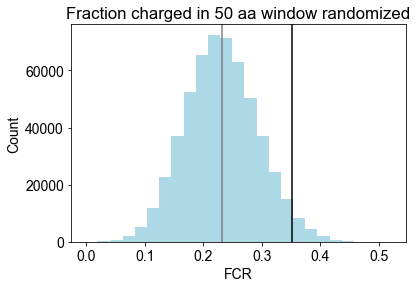

In [29]:
plt.hist(scernull_fclist, bins = 25, color = 'lightblue')
plt.axvline(x=fcnull50_mean, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=fcnull50_2sigma, ymin=0, ymax=100000, color = 'k')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged in 50 aa window randomized')
plt.show()

### Summary

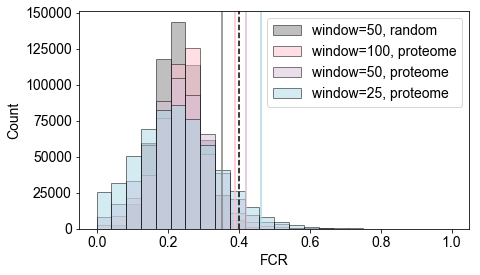

In [30]:
bnz = np.linspace(0, 1, num=25)

plt.figure(figsize=(7,4))
plt.hist(scernull_fclist, bins = bnz, color = 'gray', alpha=0.5, edgecolor='black', label = "window=50, random")
plt.hist(scer_fclist100, bins = bnz, color = 'pink', alpha=0.5, edgecolor='black', label = "window=100, proteome")
plt.hist(scer_fclist50, bins = bnz, color = 'thistle', alpha=0.5, edgecolor='black', label = "window=50, proteome")
plt.hist(scer_fclist25, bins = bnz, color = 'lightblue', alpha=0.5, edgecolor='black', label = "window=25, proteome")
plt.axvline(x=fc50_2sigma, ymin=0, ymax=100000, color = 'thistle')
plt.axvline(x=fc100_2sigma, ymin=0, ymax=100000, color = 'pink')
plt.axvline(x=fc25_2sigma, ymin=0, ymax=100000, color = 'lightblue')
plt.axvline(x=fcnull50_2sigma, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=0.4, ymin=0, ymax=100000, color = 'k', ls='--')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.legend()
plt.show()

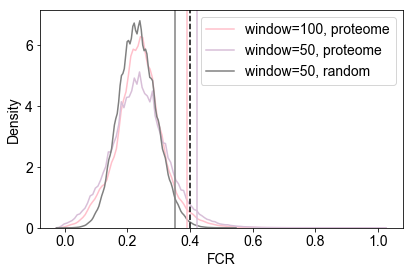

In [31]:
plt.figure(figsize=(6.5,4))

sns.kdeplot(scer_fclist100, bw=0.009, color = 'pink', label = "window=100, proteome")
sns.kdeplot(scer_fclist50, bw=0.009, color = 'thistle', label = "window=50, proteome")
sns.kdeplot(scernull_fclist, bw=0.009, color='gray', label = "window=50, random")
plt.axvline(x=fc50_2sigma, ymin=0, ymax=100000, color = 'thistle')
plt.axvline(x=fc100_2sigma, ymin=0, ymax=100000, color = 'pink')
plt.axvline(x=fcnull50_2sigma, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=0.4, ymin=0, ymax=100000, color = 'k', ls='--')
plt.xlabel('FCR')
plt.ylabel('Density')
plt.legend()
plt.show()

### Info from literature

**From Uversky 2010**

In this review/perspective entitled 'Understanding protein non-folding', the authors note that generally-speaking, disordered proteins have a lower mean hydropathy and higher mean net charge than natively folded proteins. However, it is difficult to compare these results to ours, as a) they are for entire proteins and b) the authors use a measure of 'normalized net charge' rather than the number of charged residues, to classify these sequences. Data are reproduced below:

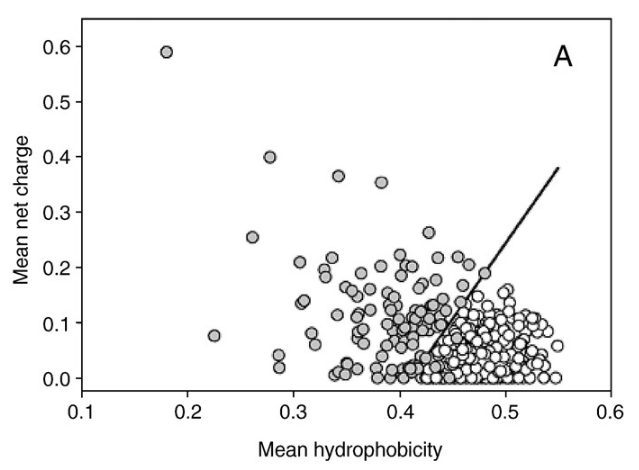

In [7]:
Image("../images/uversky-hydropathy-normalized-net-charge.png", width=400)

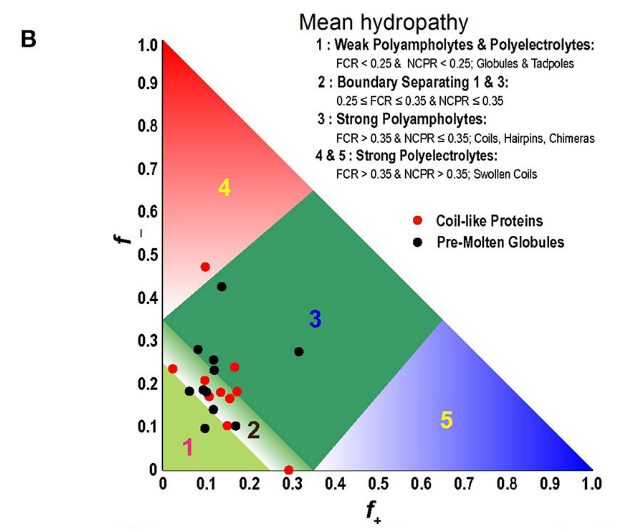

In [3]:
Image("../images/f-plus_vs_f-minus.png")

This figure, from Uversky 2019 (reprinted from Firman and Ghosh 2016) shows that anything with above an FCR of 0.35 is defined as a 'Strong polyampholyte' or 'Strong polyelectrolyte' (depending on the distribution of charges), and show that, at least for full proteins, relatively few sequences fall into these categories.

## Comparison between hits and proteome

In [32]:
entire_protein_fcrs = []
for orf in scerprot:
    seq = str(orf.seq).replace("*", "")
    entire_protein_fcrs.append(cp.fraction_charged(seq))
proteome_mean_fcr = np.mean(entire_protein_fcrs)
proteome_2sigma = proteome_mean_fcr + 2*np.std(entire_protein_fcrs)

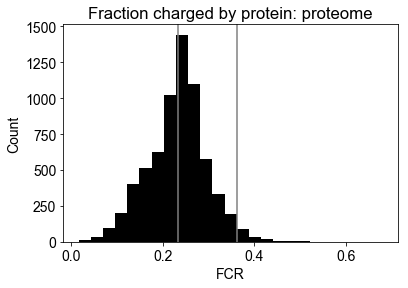

In [33]:
plt.hist(entire_protein_fcrs, bins = 25, color = 'black')
plt.axvline(x=proteome_mean_fcr, ymin=0, ymax=100000, color = 'gray')
plt.axvline(x=proteome_2sigma, ymin=0, ymax=100000, color = 'gray')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged by protein: proteome')
plt.show()

In [34]:
pan_hits_p4 = pd.read_table("../output/extract-charged-regions-output/charged-regions-medthreshold-1122.csv",
                           sep = ',', skiprows = 9, comment = "#")
hits_orfs = pd.unique(pan_hits_p4["orf"])

In [41]:
pan_hits_p4["frac.charge"]

0       0.527273
1       0.536082
2       0.500000
3       0.428571
4       0.542169
5       0.590361
6       0.431373
7       0.507937
8       0.471698
9       0.446809
10      0.458333
11      0.577465
12      0.617978
13      0.470588
14      0.458333
15      0.448276
16      0.425926
17      0.479167
18      0.464286
19      0.565789
20      0.491525
21      0.490566
22      0.423077
23      0.453125
24      0.459016
25      0.485714
26      0.648148
27      0.630952
28      0.487805
29      0.470588
          ...   
1021    0.434783
1022    0.500000
1023    0.466667
1024    0.478261
1025    0.431034
1026    0.508772
1027    0.431373
1028    0.442308
1029    0.435484
1030    0.431818
1031    0.571429
1032    0.472727
1033    0.421053
1034    0.411765
1035    0.450000
1036    0.463415
1037    0.500000
1038    0.471698
1039    0.407407
1040    0.500000
1041    0.519608
1042    0.421053
1043    0.465517
1044    0.500000
1045    0.478261
1046    0.454545
1047    0.534483
1048    0.4696

In [35]:
hits_fcrs = []
hits_no_region_fcrs = []
per_of_protein = []

for orf in scerprot:
    if orf.name in hits_orfs:
        seq = str(orf.seq).replace("*", "")
        hits_fcrs.append(cp.fraction_charged(seq))
        regions = pan_hits_p4.set_index("orf").loc[orf.name]["region.seq"]
        if (type(regions) == str):
            no_region = seq.replace(regions, "")
            if len(no_region) > 0:
                hits_no_region_fcrs.append(cp.fraction_charged(no_region))
        else:
            no_region = seq
            for i in regions:
                no_region = no_region.replace(i, "")
            if len(no_region) > 0:
                hits_no_region_fcrs.append(cp.fraction_charged(no_region))
        
        if len(no_region) > 0:
            per_of_protein.append(len(no_region) / len(seq))
        
hits_mean_fcr = np.mean(hits_fcrs)
no_region_mean_fcr = np.mean(hits_no_region_fcrs)

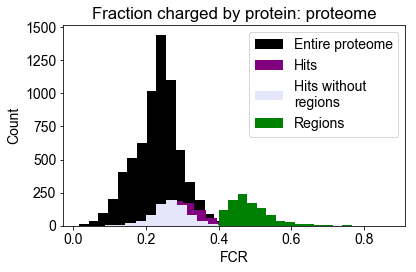

In [44]:
plt.hist(entire_protein_fcrs, bins = 25, color = 'black', label="Entire proteome")
plt.hist(hits_fcrs, bins = 12, color = 'purple', label = "Hits")
plt.hist(hits_no_region_fcrs, bins=14, color = "lavender", label = "Hits without\nregions")
plt.hist(pan_hits_p4["frac.charge"], bins = 18, color = 'green', label = "Regions")
#plt.axvline(x=proteome_mean_fcr, ymin=0, ymax=100000, color = 'gray')
#plt.axvline(x=proteome_2sigma, ymin=0, ymax=100000, color = 'gray', linestyle='--')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged by protein: proteome')
plt.legend()
plt.tight_layout()
plt.show()

/Users/Triandafillou/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


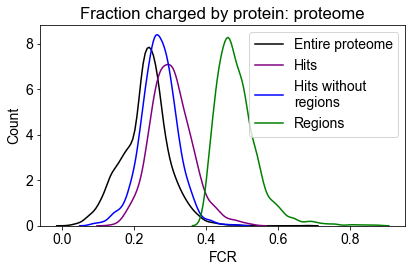

In [49]:
sns.kdeplot(entire_protein_fcrs, color = 'black', label="Entire proteome")
sns.kdeplot(hits_fcrs, color = 'purple', label = "Hits")
sns.kdeplot(hits_no_region_fcrs, color = "blue", label = "Hits without\nregions")
sns.kdeplot(pan_hits_p4["frac.charge"], color = 'green', label = "Regions")
#plt.axvline(x=proteome_mean_fcr, ymin=0, ymax=100000, color = 'gray')
#plt.axvline(x=proteome_2sigma, ymin=0, ymax=100000, color = 'gray', linestyle='--')
plt.xlabel('FCR')
plt.ylabel('Count')
plt.title('Fraction charged by protein: proteome')
plt.legend()
plt.tight_layout()
plt.show()

Highly charged regions occur in proteins that are slightly more highly charged than the rest of the proteome.

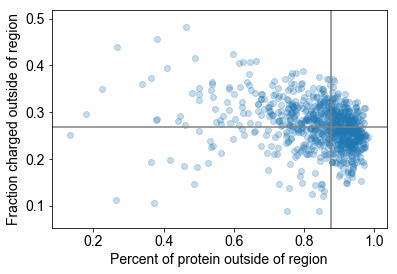

In [39]:
plt.scatter(per_of_protein, hits_no_region_fcrs, alpha = 0.25)
plt.axvline(x=np.median(per_of_protein), ymin=0, ymax=1, color='gray')
plt.axhline(y=np.median(hits_no_region_fcrs), xmin=0, xmax=1, color='gray')
plt.xlabel("Percent of protein outside of region")
plt.ylabel("Fraction charged outside of region")
plt.show()